<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Class Activation Maps (CAM) Demo
In this example notebook we are going to demonstrate the use of Class Actictivation Maps (CAM) to provide interpretability of results from CNN.  We will use the chest X-ray dataset (see our previous notebook [xrays_example.ipynb](https://github.com/AIPI540/AIPI540-Deep-Learning-Applications/blob/main/2_computer_vision/CNNs/xrays_example.ipynb)) to demonstrate CAM.  Our objective in the exercise will be to identify [pneumothorax](https://en.wikipedia.org/wiki/Pneumothorax) from chest X-ray images. 

The data we will be working with is a set of chest X-rays in the DICOM (Digital Imaging and Communications in Medicine) format.  DICOM is a standard for medical images (X-rays, MRI, CT) which allows information to be exchanged between different imaging equipment and hospitals.  DICOM files include both a header and image data and have the file extension `.dcm`.  The file header can contain equipment information, patient information, study information, etc.  The particular dataset we will work with is a subset of 250 DICOM files from the [NIH Chest X-ray Dataset](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7165201/), which includes 111,000 total chest X-ray images and associated labels of various diseases.  Of these a subset of 15302 was taken to include a mix of images labeled pneumothorax or normal.  The 250 we will use representes a small fraction of this subset.

**Notes:**
- This notebook is recommended to be run on GPU but can be run on CPU in 10-15 minutes for demo training  
- Actual training should be run for many more epochs and done on GPU

**References:**
- Read the [original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7165201/) by Filice et al. about this dataset
- Read the [paper on CAM](https://arxiv.org/pdf/1512.04150v1.pdf) by Zhou et al.
- This notebook include portions of code from the [CAM repo](https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py) by the authors of the above CAM paper


In [1]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = '2_computer_vision/model_interpretation'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: ./sample_data: No such file or directory
Cloning into 'AIPI540-Deep-Learning-Applications'...
remote: Enumerating objects: 1368, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (185/185), done.
^Cceiving objects:  25% (342/1368), 20.54 MiB | 10.21 MiB/s
fetch-pack: unexpected disconnect while reading sideband packet
[Errno 2] No such file or directory: 'AIPI540-Deep-Learning-Applications/2_computer_vision/CNNs'
/Users/jjr10/Documents/Duke/Courses/AIPI540/Spring2022/Spring2022/2_computer_vision/model_interpretation
CAM_xrays.ipynb  data/


In [1]:
import os
import urllib.request
import tarfile
import copy
import time
import numpy as np
import pandas as pd
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pydicom
import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  1.10.1


## Data preparation
### Download data

In [2]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/siim_small'):
    url = 'https://s3.amazonaws.com/fast-ai-imagelocal/siim_small.tgz'
    urllib.request.urlretrieve(url,filename='data/siim_small.tgz')
    file = tarfile.open('data/siim_small.tgz')
    file.extractall('data')
    file.close()

### Convert labels to numeric
Since PyTorch cannot work with string labels, we need to set up a mapping dictionary to convert them to integers.

In [3]:
classes = ['No Pneumothorax','Pneumothorax']
idx_to_class = {i:j for i,j in enumerate(classes)}
class_to_idx = {v:k for k,v in idx_to_class.items()}

### Create PyTorch Datasets from data and load DataLoaders

In [4]:
class DicomDataset(Dataset):
    '''
    Custom PyTorch Dataset for image classification
    Must contain 3 parts: __init__, __len__ and __getitem__
    '''

    def __init__(self, csv_path: str, data_dir: str, class_mapper: dict, transform=None):
        '''
        Args:
            csv_path (string): Path to the csv containing the image names and corresponding labels
            data_dir (string): Path to directory containing the images
            class_mapper (dict): Dictionary mapping string labels to numeric labels
            transform (callable,optional): Optional transform to be applied to images
        '''
        self.labels_df = pd.read_csv(csv_path)
        self.transform = transform
        self.data_dir = data_dir
        self.classes = self.labels_df.iloc[:,1].unique()
        self.classmapper = class_mapper

    def __len__(self):
        '''Returns the number of images in the Dataset'''
        return len(self.labels_df)

    def __getitem__(self, idx):
        '''
        Returns the image and corresponding label for an input index
        Used by PyTorch to create the iterable DataLoader

        Args:
            idx (integer): index value for which to get image and label
        '''

        # Load the image
        img_path = os.path.join(self.data_dir,
                                self.labels_df.iloc[idx, 0])
        
        # For a normal image file (jpg,png) use the below
        # image = cv2.imread(img_path) # Use this for normal color images
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Use this for color images to rearrange channels BGR -> RGB

        # Since we are dealing with DICOM files we instead load images using pydicom:
        image = pydicom.dcmread(img_path) # load the dicom file
        image = image.pixel_array # convert dicom pixel data to numpy array
        image = Image.fromarray(image) # convert numpy array to PIL image

        # Load the label
        label = self.labels_df.iloc[idx, 1]
        label = self.classmapper[label]

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [5]:
data_dir = 'data/siim_small'

data_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])])

# Create Dataset
train_dataset = DicomDataset(csv_path=os.path.join(data_dir,'labels.csv'),
                            data_dir=data_dir,
                            class_mapper=class_to_idx,
                            transform = data_transform)

# Create DataLoader
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=0)

# Store size of training set
dataset_size = len(train_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([8, 1, 224, 224])


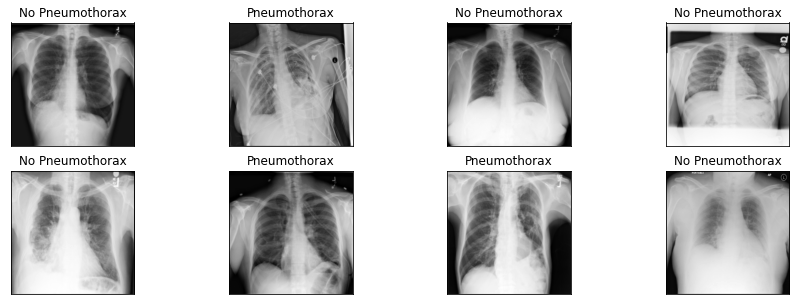

In [6]:
# Get next batch of training images
images, labels = iter(train_loader).next()
print(images.shape)
images = images.numpy() # Convert images to numpy for display
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(idx_to_class[labels[idx]])

### Define our model architecture

In [7]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was originally trained on color (3 input channels)
in_channels = 1
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (2)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)

# Display a summary of the layers of the model and output shape after each layer
summary(model_resnet,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           3,136
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]          36,864
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
       BasicBlock-11            [8, 64, 56, 56]               0
           Conv2d-12            [8, 64, 56, 56]          36,864
      BatchNorm2d-13            [8, 64, 56, 56]             128
             ReLU-14            [8, 64,

### Train the model

In [8]:
def train_model(model,criterion,optimizer,loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        running_corrects = 0
        
        for i, data in enumerate(loader):
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item() * inputs.size(0)
            # Track number of correct predictions
            running_corrects += torch.sum(preds == labels.data)
            
        # Calculate and display average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        loss_over_time.append(epoch_loss)

    return loss_over_time

Loss: 0.7103 Acc: 0.7040
Loss: 0.7080 Acc: 0.6640
Loss: 0.6808 Acc: 0.6960
Loss: 0.6631 Acc: 0.7040
Loss: 0.6520 Acc: 0.7120
Loss: 0.6469 Acc: 0.7120
Loss: 0.6459 Acc: 0.7160
Loss: 0.6339 Acc: 0.7080
Loss: 0.6055 Acc: 0.7280
Loss: 0.6225 Acc: 0.7040
Loss: 0.6295 Acc: 0.7080
Loss: 0.6129 Acc: 0.7200
Loss: 0.6433 Acc: 0.7120
Loss: 0.6085 Acc: 0.7160
Loss: 0.6322 Acc: 0.7200
Loss: 0.5900 Acc: 0.7360
Loss: 0.5940 Acc: 0.7480
Loss: 0.5747 Acc: 0.7520
Loss: 0.5950 Acc: 0.7200
Loss: 0.5757 Acc: 0.7400


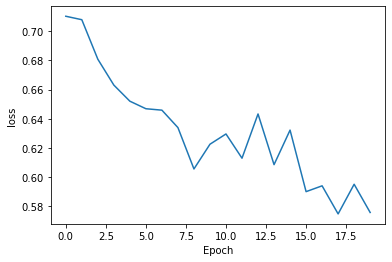

In [9]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,train_loader,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [10]:
# Save trained model for later use
model_dir = 'models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'xraymodel.pt'
torch.save(model_resnet, model_dir+filename)

In [86]:
# Load trained model
model_trained = torch.load(model_dir+filename,map_location=torch.device('cpu'))

## Implement Class Activation Mappings (CAM)
In order to use CAM we need the following:  
- The feature values after the final convolution layer  
- The weights of the fully connected layer  

To calculate the activations of each pixel for a certain class, we take the feature value after the final convolution layer and multiply them by the fully connected layer weights corresponding to that class.  This allows us to understand which pixel areas of the image were most activated for a certain class (contributed most to the prediction of that class).

In order to get the feature values after the final convolution layer in the model, we add a hook into the model which extracts and saves the feature values each time data is passed through the model using `model.forward()`.

In [87]:
# Create hook in model.forward() to extract features at the output of final conv layer
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

finalconv_name = 'layer4'
model_trained._modules.get(finalconv_name).register_forward_hook(hook_feature)

# Get the weights of the final fully connected layer (head)
params = list(model_resnet.parameters())
fc_layer_weights = np.squeeze(params[-2].data.cpu().numpy())

In order to calculate the CAM values for each pixel for a class, we take the dot product of the weights for the class of interest from the final fully connected layer and the feature values after the last convolution layer in the model.  This shows us which pixels contribute most to the final output probability for the class.

In [88]:
def calculateCAM(feature_conv, weights, class_idx):
    # Generate the class activation maps
    #size_upsample = (256, 256) # Upsample the class activation maps to 256
    size_upsample = (224,224)
    bs, nchan, h, w = feature_conv.shape # [1,512,7,7] for ResNet-18 with 1 sample passed in
    output_cam = []
    for idx in class_idx:
        # Multiply weights for class from FC layer by the output from last conv layer
        cam = weights[idx].dot(feature_conv.reshape((nchan, h*w))) 
        cam = cam.reshape(h, w) # Rehape from [1,49] to [7,7] to represent image as 7x7 activation map
        # Optional min-max scaling and rescaling to 0-255
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        output_cam.append(cv2.resize(cam, size_upsample)) # Resize to 224x224
    return output_cam

### Run the Class Activation Mapping
We can use CAM to get an activation map for each class (for every image), or we can get the CAM for a single class for each image.  For example, if we have a binary classification and we particularly want to know if an image corresponds to a certain class or not (as in this example, where we want to know whether there is evidence of pneumothorax in the xray), we can get the CAM for only that class.  

Below we will demonstrate this by getting the CAM for each image in a minibatch for the 'pneumothorax' class.  This shows us which regions of the lungs are most activated for the pneumothorax.  For images where pneumothorax is predicted, this will show us where the model believes it finds evidence of pneumothorax.

Class activation maps for class "Pneumothorax":


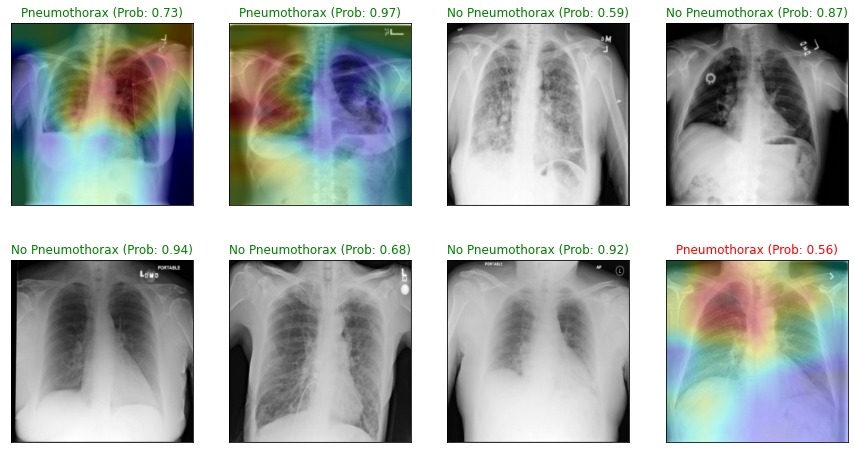

In [135]:
def run_CAM(model,dataloader,device):

    model = model.to(device)
    with torch.no_grad():
        model.eval()
        # Get a batch of images
        images, labels = iter(dataloader).next()
        images, labels = images.to(device), labels.to(device)
        labels = labels.cpu().numpy()

        print('Class activation maps for class "Pneumothorax":')
        fig = plt.figure(figsize=(15, 8))
        for idx in np.arange(len(images)):
            ax = fig.add_subplot(2, len(images)//2, idx+1, xticks=[], yticks=[])
            image = images[idx]
            label = labels[idx]
        
            # Forward pass through model to get output
            image_for_model = torch.unsqueeze(image,0)
            outputs = model(image_for_model)
            # Get probabilities for each class
            probs = F.softmax(outputs,dim=1).cpu().numpy().squeeze()
            # Get discrete prediction from class probabilities
            pred = np.argmax(probs)

            # Get image to display
            image_for_display = image.permute(1,2,0).cpu().numpy().squeeze() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
            mean = np.array([0.5])
            std = np.array([0.5])
            image_for_display = std * image_for_display + mean
            image_for_display = np.uint8(np.clip(image_for_display, 0, 1)*255)
            
            # Get Class Activation Map for predicted class
            CAM = calculateCAM(features_blobs[idx], fc_layer_weights, class_idx = [pred])
            heatmap = cv2.resize(CAM[0],(224,224)) # Make sure headmap is 224x224
            ax.imshow(image_for_display, cmap='gray')
            # Display activations for images predicted to have pneumothorax
            if pred == 1:
                ax.imshow(heatmap,alpha=0.3,cmap='jet')
            ax.set_title("{} (Prob: {:.2f})".format(idx_to_class[pred], probs[pred]),
                    color=("green" if pred==label else "red"))
    return

# Reset list of feature extractions
features_blobs = []
# Run CAM
run_CAM(model_trained,train_loader,device)